In [1]:
!pip install mljar-supervised

This workflow is really simple..

In [2]:
# import libraries
import pandas as pd
import numpy as np

from supervised.automl import AutoML

In [3]:
# make sure we can see the plots
%matplotlib inline

In [4]:
# mount to Google Drive so we can import the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# read in the data wherever you stored it
df = pd.read_csv("drive/MyDrive/migration.csv")

In [ ]:
# or you can read it in from github
# df = pd.read_csv("https://github.com/asrenninger/urbansim/raw/main/automl/migration.csv.gz")

In [6]:
# I'm listing the columns so below I can see what I want to keep
df.columns

Index(['code_i', 'code_j', 'F_ij', 'distance', 'name_i', 'name_j', 'density_i',
       'married_i', 'households_i', 'population_i', 'nonwhite_i',
       'unhealthy_i', 'employed_i', 'university_i', 'density_j', 'married_j',
       'households_j', 'population_j', 'nonwhite_j', 'unhealthy_j',
       'employed_j', 'university_j'],
      dtype='object')

AutoML has several modes— **Explain, Perform, Compete**. They all use different combinations of models to create the best prediction. The lightest, fastest possible collection of models is Explain, so we will stick with that to make it run faster.

In [8]:
# create training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    # we are going to throw out the first 2 columns
    df[df.columns[3:]], df["F_ij"], test_size=0.25
)

# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="drive/MyDrive/automl", mode='Explain')
# fit the model
automl.fit(X_train, y_train)

Linear algorithm was disabled.
This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


See that AutoML saves the model as to your folder. Go to the directory and check out the model. There should be Feature Importance images in each model folder. These compute the "importance" of each variable by shuffling them one-by-one and seeing how much a completely random version hurts model performance. What are some important features?

In [9]:
# let's store predictions
y_pred = automl.predict(X_test)

There are lot of model evaluation metrics in [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [10]:
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, r2_score
# percent error
print(mean_absolute_percentage_error(y_test, y_pred))
# absolute error
print(median_absolute_error(y_test, y_pred))
# r-squared
print(r2_score(y_test, y_pred))

1.9852429790735395
6.253464707466833
0.7671040960200681


Why do you think these are useful metrics, compared to something like RMSE?

In [11]:
# bin the predictions so we can see which parts of the distribution we are predicting best with
y_eval = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
y_eval['quantile'] = pd.qcut(y_eval['y_test'], 10, duplicates='drop')
y_eval['quantile'] = y_eval['quantile'].apply(lambda x: x.mid)

/tmp/ipython-input-1186874090.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


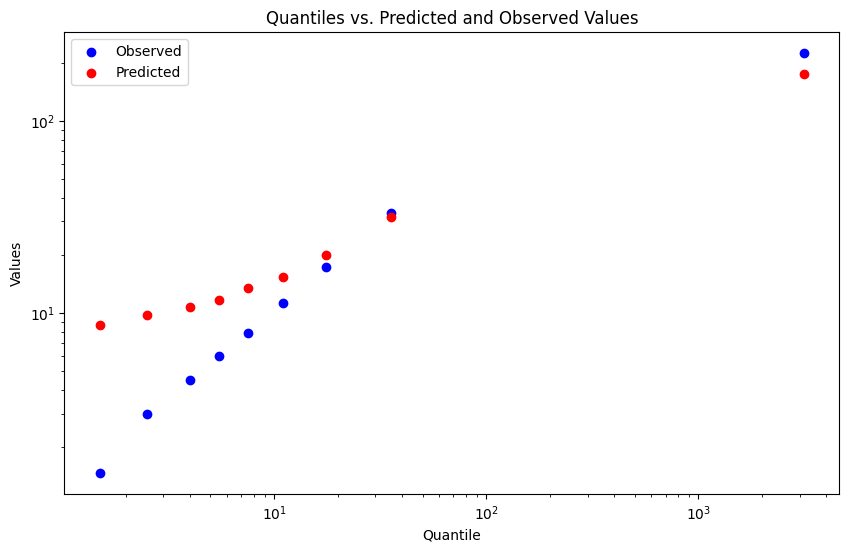

In [12]:
# average error per quantile
y_tile = y_eval.groupby('quantile', as_index=False).agg({'y_pred': 'mean', 'y_test': 'mean'})

import matplotlib.pyplot as plt
# sort the DataFrame by decile for plotting
y_tile.sort_values('quantile', inplace=True)

# create a figure and an axes instance
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot for observed values on ax
ax.scatter(y_tile['quantile'], y_tile['y_test'], color='blue', label='Observed')

# scatter plot for predicted values on ax
ax.scatter(y_tile['quantile'], y_tile['y_pred'], color='red', label='Predicted')

# adding labels and legend
ax.set_xlabel('Quantile')
ax.set_ylabel('Values')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

# show plot
plt.show()

It seems like we are predicting well everywhere except the low end of the distribution

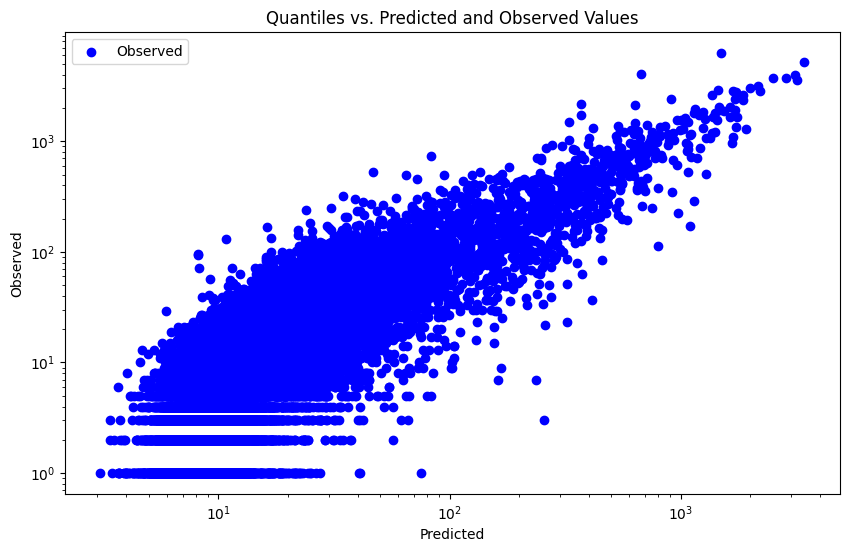

In [13]:
# predictions against observations
y_eval.sort_values('quantile', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_eval['y_pred'], y_eval['y_test'], color='blue', label='Observed')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

plt.show()

In [14]:
df.shape

(88927, 22)

# Challenge

Create a new folder called "perform", then run AutoML again with a new results_path but instead of "Explain" use "Perform" as its mode. This will use more models in the stacking and should get better results. Show some metrics from `sklearn`and plot some results; can you show that the new "Perform" model did better or worse?

In [15]:
# create training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    # we are going to throw out the first 2 columns
    df[df.columns[3:]], df["F_ij"], test_size=0.25
)

# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="perform_local", mode="Perform") # create "perform folder" and use "Perform" mode

# fit the model
automl.fit(X_train, y_train)

Linear algorithm was disabled.
AutoML directory: perform_local
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 5 models
1_Default_LightGBM rmse 74.545143 trained in 195.03 seconds (1-sample predict time 0.0634 seconds)
2_Default_Xgboost rmse 75.700905 trained in 100.49 seconds (1-sample predict time 0.08 seconds)
3_Default_CatBoost rmse 70.989174 trained in 138.85 seconds (1-sample predict time 0.0752 seconds)
4_Default_NeuralNetwork rmse 91.121584 trained in 49.74 seconds (1-sample predict time 0.1169 seconds)
5_Default_RandomForest rmse 86.060787 tra

AutoML(mode='Perform', results_path='perform_local')

In [16]:
# let's store predictions
y_pred = automl.predict(X_test)

 ### Mean Absolute Percentage, Error Median Absolute Error, R2 score

In [17]:
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, r2_score
# percent error
print(mean_absolute_percentage_error(y_test, y_pred))
# absolute error
print(median_absolute_error(y_test, y_pred))
# r-squared
print(r2_score(y_test, y_pred))

0.9296528339346299
3.4372497200147745
0.7890731665540536


In [18]:
# bin the predictions so we can see which parts of the distribution we are predicting best with
y_eval = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
y_eval['quantile'] = pd.qcut(y_eval['y_test'], 10, duplicates='drop')
y_eval['quantile'] = y_eval['quantile'].apply(lambda x: x.mid)

### Quantiles vs. Predicted and Observed Values

/tmp/ipython-input-1186874090.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


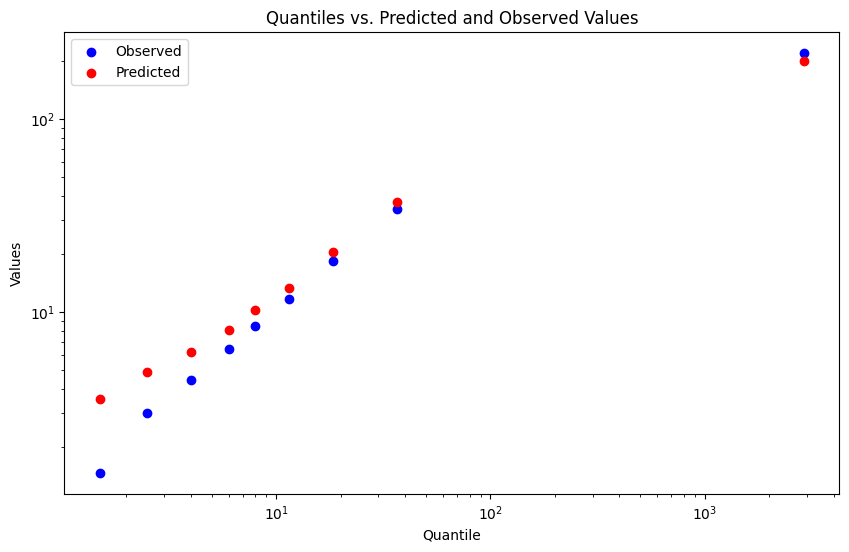

In [19]:
# average error per quantile
y_tile = y_eval.groupby('quantile', as_index=False).agg({'y_pred': 'mean', 'y_test': 'mean'})

import matplotlib.pyplot as plt
# sort the DataFrame by decile for plotting
y_tile.sort_values('quantile', inplace=True)

# create a figure and an axes instance
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot for observed values on ax
ax.scatter(y_tile['quantile'], y_tile['y_test'], color='blue', label='Observed')

# scatter plot for predicted values on ax
ax.scatter(y_tile['quantile'], y_tile['y_pred'], color='red', label='Predicted')

# adding labels and legend
ax.set_xlabel('Quantile')
ax.set_ylabel('Values')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

# show plot
plt.show()

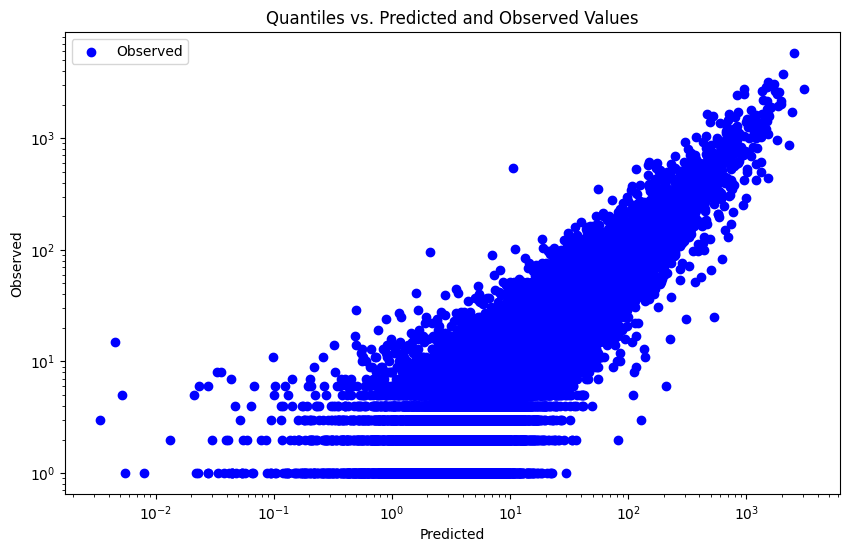

In [20]:
# predictions against observations
y_eval.sort_values('quantile', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_eval['y_pred'], y_eval['y_test'], color='blue', label='Observed')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

plt.show()

## Discussion
Did the new "Perform" model did better or worse compared to the "Explain" mode?

**Difference between Explain, Perform, Compete Mode**


In [28]:
automl_explain = AutoML(results_path="drive/MyDrive/automl", mode="Explain")
automl_explain.fit(X_train, y_train)
y_pred_explain = automl_explain.predict(X_test)

Linear algorithm was disabled.
This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


In [30]:
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, r2_score

def metrics(y_test, y_pred):
    return {
        "MAPE": mean_absolute_percentage_error(y_test, y_pred),
        "MedianAE": median_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

print("Explain:", metrics(y_test, y_pred_explain))
print("Perform:", metrics(y_test, y_pred))

Explain: {'MAPE': 1.933846105667963, 'MedianAE': 6.211722191902868, 'R2': 0.8015147814941211}
Perform: {'MAPE': 0.9296528339346299, 'MedianAE': 3.4372497200147745, 'R2': 0.7890731665540536}


> In terms of R2, Explain mode performs better results compared to Perform mode.